In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib
from matplotlib import colors,colorbar
import matplotlib
%matplotlib inline
import csv 
import math
import bq
import time

In [6]:
def get_area(lat):
    lat_degree = 69 #miles
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0        
    # phi = 90 - latitude
    phi = (lat+.05)*degrees_to_radians #plus 0.5 to get the middle
    lon_degree = math.cos(phi)*69 #miles
    # return 69*69*2.6
    return  lat_degree*lon_degree* 2.58999 #miles to square km

In [7]:
client = bq.Client.Get()
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer

In [49]:
q = '''
SELECT integer(floor(lat*10)) lat_bin, integer(floor(lon*10)) lon_bin,
sum(1/positions) vessels
FROM [scratch_david_gapanalysis.orbcomm_2015_noduplicates_st_stats]
where  
  max_lat - min_lat <5 // this lat filter cuts out 1.8 percent of the data
  // a vessel would have to be traveling faster than 
  AND (max_lon - min_lon < 10 // This lon filter cuts out 2.7 percent of the data
  // some of this data is good, but much of it may be bad
    OR first_lon > 170
    OR first_lon < -170)
  and lat > -90 and lat < 90 and lat != 0 and lon > -180 and lon < 180
  AND mmsi IN (select mmsi from
[scratch_david_gapanalysis.good_mmsi_2015])
and tagblock_type = 'terrestrial'
group by lat_bin, lon_bin
'''
vessel_query = Query(q)

Waiting on bqjob_r76234e4e068614b1_0000015302b3c36a_15 ... (0s) Current status: DONE   
Query time: 57.929833889 seconds.


In [1]:
vessel_days = np.zeros(shape=(1800,3600))

for row in vessel_query:
    lat = int(row[0])
    lon = int(row[1])
    if lat<900 and lat>-900 and lon>-1800 and lon<1800:
        lat_index = lat+900
        lon_index = lon+1800
        days = float(row[2])
        area = get_area(lat/10) # area of 1 by 1 degree at a given lat
        if days > 10:
            vessel_days[lat_index][lon_index] = days / (365* area*.1*.1) * 100000. #vessels per day per 10^5 square km


NameError: name 'np' is not defined

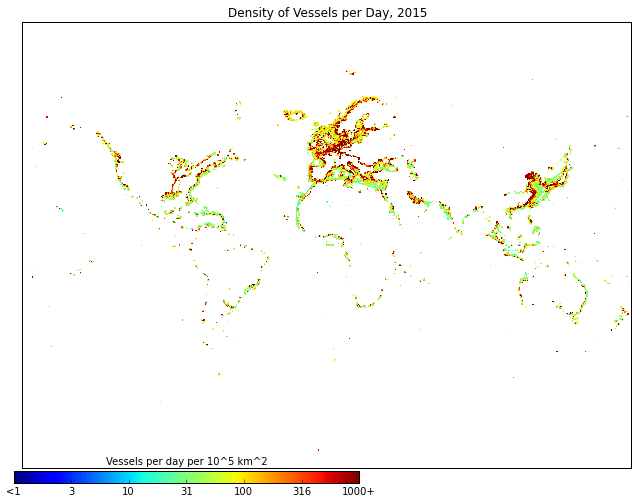

In [51]:


firstlat = 90
lastlat = -90
firstlon = -180
lastlon = 180
scale = .1

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)
    

lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=firstlon, urcrnrlon=lastlon, lat_ts=0, projection='mill',resolution="h")

m.drawmapboundary()
#     m.drawcoastlines(linewidth=.2)
#m.fillcontinents('#555555')#, lake_color, ax, zorder, alpha)


x = np.linspace(-180, 180, 360*10 )
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*10)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar

norm = colors.LogNorm(vmin=1, vmax=1000)

m3 = 10

m.pcolormesh(converted_x, converted_y, vessel_days, norm=norm, vmin=1, vmax=m3**3)
#plt.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)

t = "Density of Vessels per Day, 2015"
plt.title(t)

ax = fig.add_axes([0.15, 0.1, 0.4, 0.02]) #x coordinate , 

norm = colors.Normalize(vmin=0, vmax=1000)
norm = colors.LogNorm(vmin=1, vmax=1000)
lvls = np.logspace(0,3,7)

cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls)


cb.ax.set_xticklabels(["<1" ,int(m3**.5), m3, int(m3**1.5), m3*m3,int(m3**2.5), str(int(m3**3))+"+"], fontsize=10)
cb.set_label('Vessels per day per 10^5 km^2',labelpad=-40, y=0.45)

# plt.text(1.1, .15, 'Pixels with fewer than 20 boats per\nday in 2014 are shown in gray', fontsize = 10)
# plt.axis('off')



plt.savefig("vessel_density_2015_terrestrial_20.png",bbox_inches='tight',dpi=450,transparent=True,pad_inches=0)

plt.rcParams["figure.figsize"] = [12,8]

plt.show()

#plt.clf()


In [56]:
f = open("terrestrial_coverage.csv", "w")
for lat_bin in range(1800):
    for lon_bin in range(3600):
        if vessel_days[lat_bin][lon_bin]:
            lat = lat_bin*10-90
            lon = lon_bin*10-180
            if not(lat>-1 and lat<1 and lon>-4 and lon<4):
                f.write(str(lat_bin)+","+str(lon_bin)+","+str(vessel_days[lat_bin][lon_bin])+"\n")
f.close()